Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


___Starting group G:___
Brazil vs. Cameroon: Brazil wins with 0.75
Brazil vs. Serbia: Brazil wins with 0.70
Brazil vs. Switzerland: Brazil wins with 0.58
Cameroon vs. Serbia: Serbia wins with 0.63
Cameroon vs. Switzerland: Switzerland wins with 0.77
Serbia vs. Switzerland: Switzerland wins with 0.66


___Starting group D:___
France vs. Australia: France wins with 0.68
France vs. Denmark: Denmark wins with 0.57
France vs. Tunisia: France wins with 0.59
Australia vs. Denmark: Denmark wins with 0.76
Australia vs. Tunisia: Tunisia wins with 0.61
Denmark vs. Tunisia: Denmark wins with 0.62


___Starting group C:___
Argentina vs. Saudi Arabia: Argentina wins with 0.75
Argentina vs. Mexico: Argentina wins with 0.57
Argentina vs. Poland: Argentina wins with 0.60
Saudi Arabia vs. Mexico: Mexico wins with 0.80
Saudi Arabia vs. Poland: Poland wins with 0.76
Mexico vs. Poland: Draw


___Starting group H:___
Portugal vs. Ghana: Portugal wins with 0.73
Portugal vs. Uruguay: Portugal wins with 0.58
P

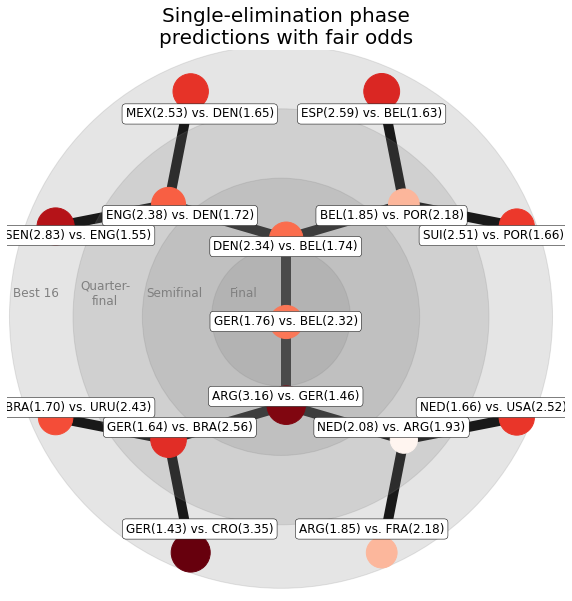

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from google.colab import drive

drive.mount('/content/drive')

rankings = pd.read_csv('/content/drive/MyDrive/soccer_data/test_data/fifa_ranking-2022-08-25.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('/content/drive/MyDrive/soccer_data/test_data/results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

world_cup = pd.read_csv('/content/drive/MyDrive/soccer_data/test_data/World Cup 2022 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match against', 'Second match against', 'Third match against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

# I tried earlier rest days but it did not turn to be useful
# min_rest = 0
# max_rest = 30
#print(matches['date'].dt.day.astype(int));

#print(matches.groupby('home_team').diff(matches['date'].dt.day))
#matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.day.astype(int).clip(min_rest,max_rest).fillna(max_rest)



# I tried earlier the team as well but that did not make a difference either
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['wc_participant']))


#테스트셋 확인
X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# figures 
# fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# plt.figure(figsize=(15,5))
# ax = plt.subplot(1,3,1)
# ax.plot([0, 1], [0, 1], 'k--')
# ax.plot(fpr, tpr)
# ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
# ax.set_aspect(1)

# ax = plt.subplot(1,3,2)
# cm = confusion_matrix(y_test, model.predict(X_test))
# ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

# ax.set_xlabel('Predicted label')
# ax.set_title('Performance on the Test set')

# ax = plt.subplot(1,3,3)
# cm = confusion_matrix(y_train, model.predict(X_train))
# ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
# ax.set_xlabel('Predicted label')
# ax.set_title('Performance on the Training set')
# pass

# #선형그래프
# features = ['average_rank', 'rank_difference', 'point_difference']
# wrongs = y_test != model.predict(X_test)

# for feature in features:
#     plt.figure()
#     plt.title(feature)
#     X_test.loc[wrongs, feature].plot.kde()
#     X.loc[:, feature].plot.kde()
#     plt.legend(['wrongs', 'all'])
    
# print("Stakes distribution in the wrong predictions")
# print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
# print("Stakes distribution overall")
# print(X['is_stake'].value_counts() / X.shape[0])

# let's define a small margin when we safer to predict draw then win



margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
# print(world_cup_rankings,'\n')
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

opponents = ['First match against', 'Second match against', 'Third match against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

# print(world_cup)

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1
            pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]
    print("\n")

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
# print(11111,'\n')
# print(world_cup)
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
# print(22222,'\n')
# print(next_round_wc)
next_round_wc = next_round_wc.reset_index()
# print(33333,'\n')
# print(next_round_wc)
next_round_wc = next_round_wc.loc[pairing]
# print(44444,'\n')
# print(next_round_wc)
next_round_wc = next_round_wc.set_index('Team')
# print(55555,'\n')
# print(next_round_wc)

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'third_place_match','final']

labels = list()
odds = list()

final_two = []
for f in finals:
    print("___Starting of the {}___".format(f))
    winners = []
    third = []

    if f=='final':
      iterations = int(len(next_round_wc))
    else:
      iterations = int(len(next_round_wc) / 2)

    for i in range(iterations):
        if f=='third_place_match':
          home = next_round_wc.index[i*2+2]
          away = next_round_wc.index[i*2+3]

        else :  
          home = next_round_wc.index[i*2]
          away = next_round_wc.index[i*2+1]

        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]



        if f == 'third_place_match':
          if (f == 'third_place_match') and (model.predict_proba(row)[:,1] <= 0.5):
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))

          else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))

        else:
          if model.predict_proba(row)[:,1] <= 0.5:
              print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
              if f == 'semifinal':
                third.append(home)
                final_two.append(away)
              else:  
                winners.append(away)        

          else:
              print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
              if f == 'semifinal':
                third.append(away)
                final_two.append(home)
              else:
                winners.append(home)


          labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                      1/home_win_prob, 
                                                      world_cup_rankings.loc[away, 'country_abrv'], 
                                                      1/(1-home_win_prob)))
          odds.append([home_win_prob, 1-home_win_prob])
        
        if f=='third_place_match' or f=='final':
          break

    if f=='semifinal':                
        next_round_wc = next_round_wc.loc[final_two+third]
    elif f=='third_place_match':
        next_round_wc = next_round_wc.loc[final_two]
    else:
        next_round_wc = next_round_wc.loc[winners]
    # print(next_round_wc)

    print("\n")


node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph

nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()